In [1]:
import os
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import spacy
import re
import contractions
import unicodedata
import nltk
import string

# Load nltk stopwords
from nltk.corpus import stopwords

In [3]:
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import warnings

<div class="alert alert-block alert-info" align=center><b></b>
    
# **Vector Embeddings** 

## **Data Preprocessing**

In [9]:
!pip install -q spacy contractions nltk

In [8]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 15.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
#!pip install numpy==1.26.4

In [5]:
ml_pbfiqa_df = pd.read_csv("Dataset/Cleaned Sentence Data/Cleaned Phrasebank and FiQa.csv")
nn_pbfiqa_df = ml_pbfiqa_df.copy()

In [6]:
ml_ar_df = pd.read_csv("Dataset/Cleaned Sentence Data/Cleaned Annual Reports.csv")
nn_ar_df = ml_ar_df.copy()

In [10]:
nlp_model = spacy.load('en_core_web_lg') # On UCLoud, change this from 'en_core_web_sm' to 'en_core_web_md' or 'en_core_web_lg' since there's more RAM

In [11]:
stop_words = set(stopwords.words('english'))

sentiment_holding_stopwords = {'above', 'against', 'below', 'but', 'down', 'few', 'further', 'most', 'no', 'nor', 'not', 'off', 'over', 'own', 'too', 'up', 'very'}
stop_words = stop_words - sentiment_holding_stopwords

# Lemmatize stop words
stop_words = set(
    nlp_model(word)[0].lemma_
    for word in stop_words
)

In [12]:
class TextNormalizer:
    """
    Text normalizer class. When passed a string of text, it will normalize the text by:
    1. Expanding contractions.
    2. Removing stopwords.
    3. Lemmatizing the text or stemming the text.
    4. Removing special characters.
    5. Converting the text to lowercase.
    This is done sequentially.
    """
    def __init__(self):
        self.stopwords = stop_words
        #self.lemmatizer = lemmatizer
        self.nlp = nlp_model

    def normalize(self, text, rm_stopwords=True, rm_special_chars=True, expand_cont=True, 
                  case_convert=True, lemmatize=True, remove_numbers=True,
                  remove_accented_chars=True, scrub_words=True, tokenize=True):
        """
        Normalize the text by applying a series of text processing steps.
        rm_stopwords -> Boolean: Removes stopwords from the text.
        rm_special_chars -> Boolean: Removes special characters from the text.
        expand_cont -> Boolean: Expands contractions in the text.
        case_convert -> Boolean: Converts the text to lowercase.
        lemmatize -> Boolean: Lemmatizes the text.
        """
        if not isinstance(text, str):
            raise ValueError("Input text must be a string")
        if expand_cont:
            text = self.expand_contractions(text)
        if remove_accented_chars:
            text = self.remove_accented_chars(text)
        if case_convert:
            text = self.case_convert(text, True)
        else:
            text = self.case_convert(text, False)
        if remove_numbers:
            text = self.remove_numbers(text)
        if scrub_words:
            text = self.scrub_words(text)
        
        if not tokenize:
            return text
        
        doc = self.nlp(text)

        tokens = [token.text for token in doc]

        if lemmatize:
            tokens = [token.lemma_ for token in doc if not token.is_punct]

        if rm_stopwords:
            tokens = [token for token in tokens if token not in self.stopwords]

        if rm_special_chars:
            tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]
            tokens = [token for token in tokens if token]  # Remove empty strings

        return ' '.join(tokens)        
     

    # Define the text processing methods
    def expand_contractions(self, text):
        return contractions.fix(text)
    
    def remove_accented_chars(self, text):
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    def scrub_words(self, text):
        # Replace \xa0 characters in text
        text = re.sub(r'\xa0', ' ', text)
        # Replace non ascii / not words and digits
        text = re.sub(r"([^\w\d])", ' ', text)
        # Replace new line characters and following text until space
        text = re.sub(r'\n(\w*?)[\s]', '', text)
        # Remove html markup
        text = re.sub(r"<.*?>", ' ', text)
        # Remove extra spaces from the text
        text = re.sub(r"\s+", ' ', text)
        return text.strip()

    def case_convert(self, text, lower=True):
        if lower:
            return text.lower()
        else:
            return text.upper()
        
    def remove_numbers(self, text):
        return re.sub(r'\d+', '', text)

In [13]:
ml_normalizer = TextNormalizer()
nn_normalizer = TextNormalizer()

In [14]:
ml_pbfiqa_df['Sentence'] = ml_pbfiqa_df['Sentence'].apply(lambda x: ml_normalizer.normalize(x))
ml_pbfiqa_df.head()

,Sentence,Sentiment
0,geosolution technology leverage benefon gps so...,positive
1,esi low down bk real possibility,negative
2,last quarter componenta net sale double eurm e...,positive
3,accord finnish russian chamber commerce major ...,neutral
4,swedish buyout firm sell remain percent stake ...,neutral


In [15]:
ml_ar_df['Sentence'] = ml_ar_df['Sentence'].apply(lambda x: ml_normalizer.normalize(x))
ml_ar_df.head()

,Sentence,Sentiment
0,global electricity demand project double drive...,positive
1,exact electricity demand depend much electrifi...,neutral
2,future demand meet affordable secure renewable...,neutral
3,renewable industry see substantial build recen...,positive
4,diversify energy portfolio include high share ...,neutral


In [16]:
nn_pbfiqa_df['Sentence'] = nn_pbfiqa_df['Sentence'].apply(lambda x: nn_normalizer.normalize(x, tokenize=False, lemmatize=False, rm_stopwords=False, rm_special_chars=False))
nn_pbfiqa_df.head()

,Sentence,Sentiment
0,the geosolutions technology will leverage bene...,positive
1,esi on lows down to bk a real possibility,negative
2,for the last quarter of componenta s net sales...,positive
3,according to the finnish russian chamber of co...,neutral
4,the swedish buyout firm has sold its remaining...,neutral


In [17]:
nn_ar_df['Sentence'] = nn_ar_df['Sentence'].apply(lambda x: nn_normalizer.normalize(x, tokenize=False, lemmatize=False, rm_stopwords=False, rm_special_chars=False))
nn_ar_df.head()

,Sentence,Sentiment
0,global electricity demand is projected to doub...,positive
1,while the exact electricity demand depends on ...,neutral
2,future demand must be met by affordable secure...,neutral
3,the renewables industry has seen substantial b...,positive
4,diversified energy portfolios including a high...,neutral


NB: Final clean because two sentences was missing with ""

In [18]:
# Find empty string values in the 'Sentence' column
len(ml_pbfiqa_df[ml_pbfiqa_df['Sentence'].str.strip()==""]), len(ml_ar_df[ml_ar_df['Sentence']==""])

(2, 0)

In [19]:
# Remove empty string values in the 'Sentence' column
ml_pbfiqa_df = ml_pbfiqa_df[ml_pbfiqa_df['Sentence'].str.strip() != '']

In [20]:
# Check again
len(ml_pbfiqa_df[ml_pbfiqa_df['Sentence'].str.strip()==""]), len(ml_ar_df[ml_ar_df['Sentence']==""])

(0, 0)

#### Export to CSV

In [21]:
os.makedirs("Dataset/Preprocessed/", exist_ok=True)

In [ ]:
ml_pbfiqa_df.to_csv("Dataset/Preprocessed/ml_pbfiqa.csv", index=False)
ml_ar_df.to_csv("Dataset/Preprocessed/ml_ar.csv", index=False)
nn_pbfiqa_df.to_csv("Dataset/Preprocessed/nn_pbfiqa.csv", index=False)
nn_ar_df.to_csv("Dataset/Preprocessed/nn_ar.csv", index=False)

## **Machine Learning Models**

In [ ]:
#!pip install -q scikit-learn tensorflow
#!pip install -q --upgrade numpy scikit-learn

In [22]:
# -------------------------------
# Step 1: Pre-train on ml_pbfiqa.csv
# -------------------------------
pretrain_df = pd.read_csv("Dataset/Preprocessed/ml_pbfiqa.csv")
X_pretrain = pretrain_df['Sentence']
y_pretrain = pretrain_df['Sentiment']

# -------------------------------
# Step 2: Prepare ar.csv for evaluation
# -------------------------------
ar_df = pd.read_csv("Dataset/Preprocessed/ml_ar.csv")
X_ar = ar_df['Sentence']
y_ar = ar_df['Sentiment']
X_train_ar, X_test_ar, y_train_ar, y_test_ar = train_test_split(X_ar, y_ar, test_size=0.2, random_state=42)

# -------------------------------
# Define Models and Hyperparameters
# -------------------------------
pipelines = {
    "Logistic Regression": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000,
                                  lowercase=False,       # already lowercased
                                  stop_words=None       # already removed
    )),
        ('clf', LogisticRegression(max_iter=1000))
    ]),
    "SVM": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000,
                                  lowercase=False,       # already lowercased
                                  stop_words=None       # already removed
    )),
        ('clf', SVC())
    ]),
    "Naive Bayes": Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000,
                                  lowercase=False,       # already lowercased
                                  stop_words=None       # already removed
    )),
        ('clf', MultinomialNB())
    ])
}

param_grids = {
    "Logistic Regression": {
        'tfidf__ngram_range': [(1,1), (1,2)],
        'clf__C': [0.1, 1, 10]
    },
    "SVM": {
        'tfidf__ngram_range': [(1,1), (1,2)],
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    },
    "Naive Bayes": {
        'tfidf__ngram_range': [(1,1), (1,2)],
        'clf__alpha': [0.5, 1.0, 1.5]
    }
}

# -------------------------------
# Train on pretrain_df and fine-tune/test on ar_df
# -------------------------------
for name, pipeline in pipelines.items():
    print(f"\nPre-training {name} on Phrasebank + FiQA...")
    pipeline.fit(X_pretrain, y_pretrain)

    print(f"Fine-tuning {name} on Annual Report training set...")
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train_ar, y_train_ar)

    print(f"Best Params for {name}: {grid.best_params_}")
    print(f"Classification Report on Annual Report test set:")
    y_pred = grid.predict(X_test_ar)

    
    # Save classification report
    report = classification_report(y_test_ar, y_pred, target_names=sorted(y_ar.unique()), digits=4)
    print(report)


Pre-training Logistic Regression on Phrasebank + FiQA...
Fine-tuning Logistic Regression on Annual Report training set...
Best Params for Logistic Regression: {'clf__C': 10, 'tfidf__ngram_range': (1, 1)}
Classification Report on Annual Report test set:
              precision    recall  f1-score   support

    negative     0.8571    0.6102    0.7129        59
     neutral     0.9121    0.9753    0.9427       649
    positive     0.9043    0.7975    0.8475       237

    accuracy                         0.9079       945
   macro avg     0.8912    0.7943    0.8344       945
weighted avg     0.9067    0.9079    0.9045       945


Pre-training SVM on Phrasebank + FiQA...
Fine-tuning SVM on Annual Report training set...
Best Params for SVM: {'clf__C': 10, 'clf__kernel': 'linear', 'tfidf__ngram_range': (1, 2)}
Classification Report on Annual Report test set:
              precision    recall  f1-score   support

    negative     0.8400    0.7119    0.7706        59
     neutral     0.9284  

## **Neural Netowrk (LSTM)**

In [ ]:
# !pip install -q tensorflow=2.16.1 keras_tuner

In [23]:
warnings.filterwarnings("ignore")

# Constants
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100
PRETRAIN_WEIGHTS_PATH = "pretrained_lstm.weights.h5"

# === Load Pretraining Data ===
pretrain_df = pd.read_csv("Dataset/Preprocessed/nn_pbfiqa.csv")
texts_pretrain = pretrain_df['Sentence'].astype(str)
labels_pretrain = pretrain_df['Sentiment']

label_encoder = LabelEncoder()
labels_pretrain_encoded = label_encoder.fit_transform(labels_pretrain)

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(texts_pretrain)
X_pretrain = pad_sequences(tokenizer.texts_to_sequences(texts_pretrain), maxlen=MAX_SEQUENCE_LENGTH)

# === Define Model Function ===
def build_model(hp=None, load_pretrained=False):
    lstm_units = 64
    dense_units = 64
    dense_dropout = 0.3
    learning_rate = 1e-3

    if hp and not load_pretrained:
        # Only allow tuning if not loading pretrained weights
        dense_units = hp.Int("dense_units", 32, 128, step=32)
        dense_dropout = hp.Float("dense_dropout", 0.1, 0.5, step=0.1)
        learning_rate = float(hp.Choice("learning_rate", [1e-3, 1e-4]))

    model = Sequential()
    model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, trainable=True))
    model.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2))  # Fixed
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(dense_dropout))
    model.add(Dense(len(np.unique(labels_pretrain_encoded)), activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    if load_pretrained:
        model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
        try:
            model.load_weights(PRETRAIN_WEIGHTS_PATH)
        except Exception as e:
            print("Warning: Couldn't load pretrained weights:", e)

    return model

# === Pretrain ===
print("=== Pretraining ===")
pretrain_model = build_model()
pretrain_model.fit(X_pretrain, labels_pretrain_encoded, epochs=20, batch_size=32, validation_split=0.2,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])
pretrain_model.save_weights(PRETRAIN_WEIGHTS_PATH)

# === Load Fine-Tuning Data ===
train_df = pd.read_csv("Dataset/Preprocessed/nn_ar.csv")
texts_finetune = train_df['Sentence'].astype(str)
labels_finetune = label_encoder.transform(train_df['Sentiment'])

X_finetune = pad_sequences(tokenizer.texts_to_sequences(texts_finetune), maxlen=MAX_SEQUENCE_LENGTH)
X_train, X_test, y_train, y_test = train_test_split(X_finetune, labels_finetune, test_size=0.2, random_state=42)

# === Fine-tune with Keras Tuner ===
# Phase 1: HYPERPARAMETER TUNING WITHOUT pretrained weights
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, load_pretrained=False),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='tune_architecture'
)

tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)

# Phase 2: LOAD BEST HPs and retrain WITH pretrained weights
best_hp = tuner.get_best_hyperparameters(1)[0]
model = build_model(best_hp, load_pretrained=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)


# === Evaluate Best Model ===
best_model = tuner.get_best_models(1)[0]
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print("\n=== Evaluation ===")
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, digits=4)
print(report)

Trial 10 Complete [00h 01m 42s]
val_accuracy: 0.9193121790885925

Best val_accuracy So Far: 0.9695767164230347
Total elapsed time: 00h 12m 51s
Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.6875 - loss: 0.7666 - val_accuracy: 0.8214 - val_loss: 0.5035
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8808 - loss: 0.3901 - val_accuracy: 0.8889 - val_loss: 0.3189
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9397 - loss: 0.1842 - val_accuracy: 0.9458 - val_loss: 0.1922
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9761 - loss: 0.0794 - val_accuracy: 0.9603 - val_loss: 0.1938
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9848 - loss: 0.0572 - val_accuracy: 0.9656 - val_loss: 0.1809
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9964 - loss: 0.0203 - val_accuracy: 0.9524 - val_loss: 0.1742
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9918 - loss: 0.0291 - val_accu

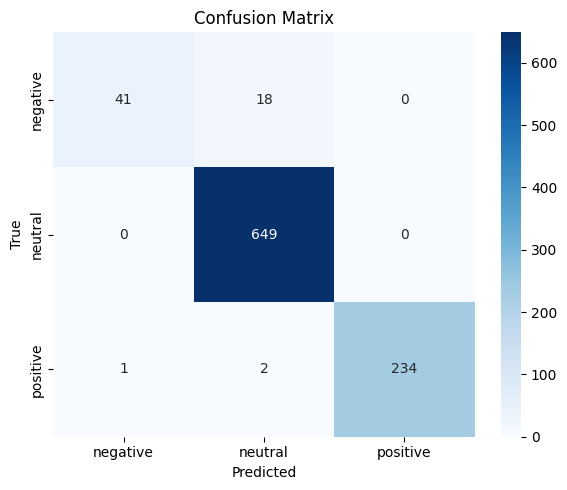

In [24]:

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot and save
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

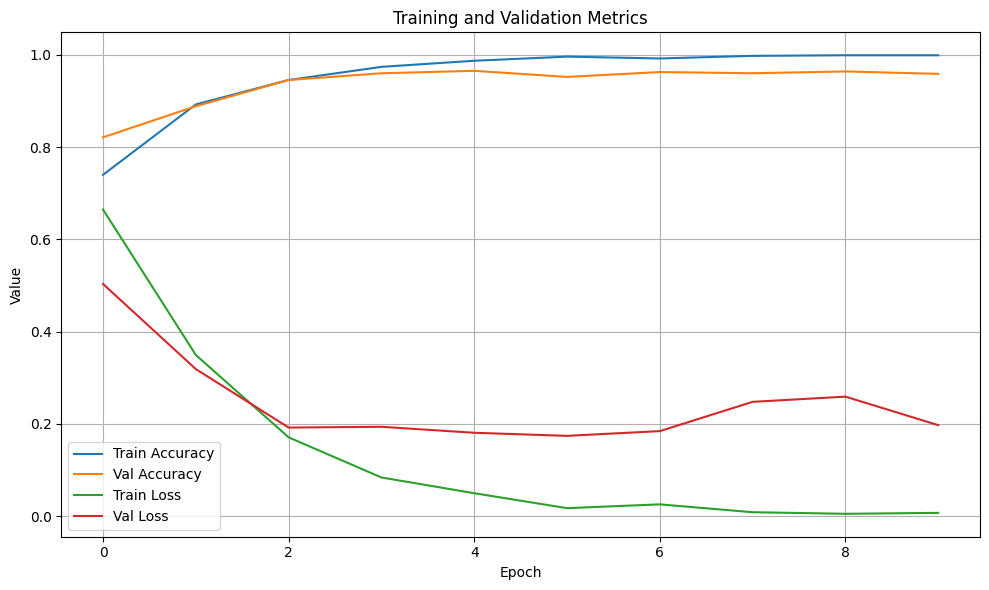

In [25]:
# Convert training history to DataFrame
history_df = pd.DataFrame(history.history)

# Plot all in one figure
plt.figure(figsize=(10, 6))

# Accuracy
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Val Accuracy')

# Loss
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Val Loss')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()